In [1]:
import csv
import os
import random
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from matplotlib import transforms
import sklearn
import warnings
import numpy as np
import nibabel as nib
from nilearn.image import coord_transform
import mne
from mne import vertex_to_mni
from nilearn.plotting import plot_connectome

In [ ]:
print(pd.read_csv('/brainbody/fMRI.aparc.csv')['label_name'].to_list())
print(pd.read_csv('/brainbody/fMRI.Tian_Subcortex_S1_3T.csv')['label_name'].to_list())

['left_bankssts', 'left_caudalanteriorcingulate', 'left_caudalmiddlefrontal', 'left_cuneus', 'left_entorhinal', 'left_fusiform', 'left_inferiorparietal', 'left_inferiortemporal', 'left_isthmuscingulate', 'left_lateraloccipital', 'left_lateralorbitofrontal', 'left_lingual', 'left_medialorbitofrontal', 'left_middletemporal', 'left_parahippocampal', 'left_paracentral', 'left_parsopercularis', 'left_parsorbitalis', 'left_parstriangularis', 'left_pericalcarine', 'left_postcentral', 'left_posteriorcingulate', 'left_precentral', 'left_precuneus', 'left_rostralanteriorcingulate', 'left_rostralmiddlefrontal', 'left_superiorfrontal', 'left_superiorparietal', 'left_superiortemporal', 'left_supramarginal', 'left_frontalpole', 'left_temporalpole', 'left_transversetemporal', 'left_insula', 'right_bankssts', 'right_caudalanteriorcingulate', 'right_caudalmiddlefrontal', 'right_cuneus', 'right_entorhinal', 'right_fusiform', 'right_inferiorparietal', 'right_inferiortemporal', 'right_isthmuscingulate', '

In [ ]:
# 1 Get MNI coordinates
# =============================================
# For Subcortical (Tian S1)
# =============================================
tian_s1 = nib.load("/feature-imp/dwi/Tian_Subcortex_S1_3T.nii.gz")
tian_data = tian_s1.get_fdata()
labels = np.unique(tian_data)[1:]  # Exclude background (0)

# Compute centroids in voxel space and convert to MNI
voxel_coords = np.array([np.mean(np.argwhere(tian_data == label), axis=0) for label in labels])
mni_coords_subcortical = np.array([
    coord_transform(x, y, z, tian_s1.affine) 
    for x, y, z in voxel_coords
])

# =============================================
# For Cortical (Desikan-Killiany) - Using MNE
# =============================================
subjects_dir = '/dwi/examples/dallas_qsiprep/preproc/subjects/sub/freesurfer'
subject = 'fsaverage'
annot = mne.read_labels_from_annot(subject, parc='aparc', subjects_dir=subjects_dir)

dk_mni_coords = []
dk_names = []
dk_hemis = []

dk_mni_coords = []
dk_names = []
dk_hemis = []

for label in annot:
    try:
        # Extract clean name and hemisphere
        name_parts = label.name.split('-')
        if len(name_parts) == 2:  # Format: "region-lh" or "region-rh"
            clean_name = name_parts[0]  # e.g. "bankssts"
            hemi_str = name_parts[1]   # e.g. "lh"
        else:  # Fallback for other formats
            clean_name = label.name
            hemi_str = 'lh' if 'lh' in label.name.lower() else 'rh'
        
        # Get MNI coordinates
        vertex = label.center_of_mass(subject=subject, subjects_dir=subjects_dir)
        mni_coord = vertex_to_mni(
            vertices=[vertex],
            hemis=[0 if hemi_str == 'lh' else 1],  # 0=left, 1=right
            subject=subject,
            subjects_dir=subjects_dir
        )[0]
        
        # Force negative X for left hemisphere
        if hemi_str == 'lh' and mni_coord[0] > 0:
            mni_coord[0] *= -1
        
        dk_mni_coords.append(mni_coord)
        dk_names.append(f"{clean_name}-{hemi_str}")  # e.g. "bankssts-lh"
        dk_hemis.append(hemi_str)
        
    except Exception as e:
        print(f"Skipping {label.name}: {str(e)}")
        continue

# Convert to properly shaped numpy array (n_regions × 3)
if dk_mni_coords:  # Only if we have coordinates
    dk_mni_coords = np.vstack(dk_mni_coords)  # This creates a 2D array
else:
    dk_mni_coords = np.empty((0, 3))  # Empty array if no coords

# =============================================
# 3. Combine Subcortical + Cortical Coordinates
# =============================================
# Subcortical (Tian)
# Load Tian label names
tian_label_path = "/feature-imp/dwi/Tian_Subcortex_S1_3T_label.txt"
with open(tian_label_path, 'r') as f:
    tian_labels = [line.strip() for line in f.readlines()]

print("Tian subcortical labels:")
print(tian_labels)
# Subcortical (Tian)

subcortical_data = {
    'name': tian_labels[:len(labels)],  # Use actual names instead of Tian_1, etc.
    'x.mni': mni_coords_subcortical[:, 0],
    'y.mni': mni_coords_subcortical[:, 1],
    'z.mni': mni_coords_subcortical[:, 2],
    'hemi': ['left' if '-lh' in name or '-l' in name.lower() else 'right' for name in tian_labels[:len(labels)]],
    'type': ['subcortical'] * len(labels)
}

# Filter out unknown regions before creating all_coords
dk_names_filtered = []
dk_mni_coords_filtered = []
dk_hemis_filtered = []

for name, coord, hemi in zip(dk_names, dk_mni_coords, dk_hemis):
    if 'unknown' not in name:
        dk_names_filtered.append(name)
        dk_mni_coords_filtered.append(coord)
        dk_hemis_filtered.append(hemi)

# Cortical (DK)
cortical_data = {
    'name': dk_names_filtered,
    'x.mni': np.array(dk_mni_coords_filtered)[:, 0],
    'y.mni': np.array(dk_mni_coords_filtered)[:, 1],
    'z.mni': np.array(dk_mni_coords_filtered)[:, 2],
    'hemi': dk_hemis_filtered,
    'type': ['cortical'] * len(dk_names_filtered)
}

# Merge into one DataFrame
all_coords = pd.concat([
    pd.DataFrame(cortical_data),
    pd.DataFrame(subcortical_data)
], ignore_index=True)

print("Successfully created coordinate dataframe:")
print(all_coords.head())

aparc_s1_coords = all_coords.copy()

# Convert all hemisphere labels to 'lh'/'rh'
aparc_s1_coords['hemi'] = aparc_s1_coords['hemi'].map({
    'left': 'lh',
    'right': 'rh',
    'lh': 'lh',  # keeps existing lh
    'rh': 'rh'  # keeps existing rh
})

print("Standardized hemispheres:")
print(aparc_s1_coords['hemi'].unique())

aparc_s1_coords.to_csv('/feature-imp/dwi/aparc_s1_coords_mni.csv', index=False)
aparc_s1_coords[['x.mni', 'y.mni', 'z.mni']].to_csv('/feature-imp/dwi/aparc_s1_coords_mni.txt', index=False)

In [38]:
aparc_s1_coords

,name,x.mni,y.mni,z.mni,hemi,type
0,bankssts-lh,-49.082870,-43.747719,4.039768,lh,cortical
1,bankssts-rh,44.973549,-39.531868,6.709673,rh,cortical
2,caudalanteriorcingulate-lh,-5.065071,19.156570,26.371817,lh,cortical
3,caudalanteriorcingulate-rh,5.718488,19.710270,26.580164,rh,cortical
4,caudalmiddlefrontal-lh,-40.711433,14.641522,48.526733,lh,cortical
...,...,...,...,...,...,...
79,aTHA-lh,-7.981567,-14.608295,8.642857,lh,subcortical
80,NAc-lh,-10.737864,14.271845,-5.106796,lh,subcortical
81,GP-lh,-18.121212,-3.818182,-1.696970,lh,subcortical
82,PUT-lh,-24.786192,0.440980,0.835189,lh,subcortical


In [5]:
print("\nHemisphere verification:")
for i, (name, coord, hemi) in enumerate(zip(dk_names, dk_mni_coords, dk_hemis)):
    if i < 5 or hemi == 'lh':  # Print first 5 and any left-hemisphere
        print(f"{name}: X={coord[0]:.1f} (should be {'negative' if hemi == 'lh' else 'positive'})")

print("\nFinal hemisphere counts:")
print(pd.Series(dk_hemis).value_counts())

print("\nX-coordinate ranges:")
print(f"Left cortex: {min([c[0] for c, h in zip(dk_mni_coords, dk_hemis) if h == 'lh']):.1f} to {max([c[0] for c, h in zip(dk_mni_coords, dk_hemis) if h == 'lh']):.1f}")
print(f"Right cortex: {min([c[0] for c, h in zip(dk_mni_coords, dk_hemis) if h == 'rh']):.1f} to {max([c[0] for c, h in zip(dk_mni_coords, dk_hemis) if h == 'rh']):.1f}")


Hemisphere verification:
bankssts-lh: X=-49.1 (should be negative)
bankssts-rh: X=45.0 (should be positive)
caudalanteriorcingulate-lh: X=-5.1 (should be negative)
caudalanteriorcingulate-rh: X=5.7 (should be positive)
caudalmiddlefrontal-lh: X=-40.7 (should be negative)
cuneus-lh: X=-3.7 (should be negative)
entorhinal-lh: X=-23.5 (should be negative)
frontalpole-lh: X=-8.0 (should be negative)
fusiform-lh: X=-35.3 (should be negative)
inferiorparietal-lh: X=-40.9 (should be negative)
inferiortemporal-lh: X=-54.0 (should be negative)
insula-lh: X=-36.5 (should be negative)
isthmuscingulate-lh: X=-8.3 (should be negative)
lateraloccipital-lh: X=-28.7 (should be negative)
lateralorbitofrontal-lh: X=-26.7 (should be negative)
lingual-lh: X=-12.7 (should be negative)
medialorbitofrontal-lh: X=-5.1 (should be negative)
middletemporal-lh: X=-63.6 (should be negative)
paracentral-lh: X=-5.7 (should be negative)
parahippocampal-lh: X=-24.2 (should be negative)
parsopercularis-lh: X=-52.5 (sh

In [6]:
print("Unique hemispheres in cortical regions:", aparc_s1_coords[aparc_s1_coords['type']=='cortical']['hemi'].unique())
print("Unique hemispheres in subcortical:", aparc_s1_coords[aparc_s1_coords['type']=='subcortical']['hemi'].unique())

Unique hemispheres in cortical regions: ['lh' 'rh']
Unique hemispheres in subcortical: ['rh' 'lh']


In [ ]:
aparc_s1_coords = pd.read_csv('/feature-imp/dwi/aparc_s1_coords_mni.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(aparc_s1_coords.round(2))

,name,x.mni,y.mni,z.mni,hemi,type
0,bankssts-lh,-49.08,-43.75,4.04,lh,cortical
1,bankssts-rh,44.97,-39.53,6.71,rh,cortical
2,caudalanteriorcingulate-lh,-5.07,19.16,26.37,lh,cortical
3,caudalanteriorcingulate-rh,5.72,19.71,26.58,rh,cortical
4,caudalmiddlefrontal-lh,-40.71,14.64,48.53,lh,cortical
5,caudalmiddlefrontal-rh,41.61,15.69,47.76,rh,cortical
6,cuneus-lh,-3.71,-76.29,20.17,lh,cortical
7,cuneus-rh,4.25,-79.06,21.83,rh,cortical
8,entorhinal-lh,-23.55,-7.40,-33.48,lh,cortical
9,entorhinal-rh,24.76,-6.05,-33.71,rh,cortical


In [ ]:
# 2 Get correlations between best DWI modality and predicted g-factor
modality = '31021_connectome_streamline_count'
warnings.simplefilter(action='ignore', category=FutureWarning)

############## 1
seed = 42
folds = ["0", "1", "2", "3", "4"]
modality_dfs = {}

features = []
g_pred = []
pls_result = {}

for fold in folds:
    features_corrected = pd.read_csv(f'/Cog-Ment/PLS/brain/dti/dti_struct/fold_{fold}/scaling/{modality}_test_corr_{fold}.csv')
    g_pred_test = pd.read_csv(f'/Cog-Ment/PLS/brain/dti/dti_struct/fold_{fold}/g_pred/{modality}_g_pred_test_id_fold_{fold}.csv').drop(columns=['Unnamed: 0', 'eid'])
        
    features.append(features_corrected)
    g_pred.append(g_pred_test)
    
features_five_folds= pd.concat(features, axis=0, ignore_index=True)
g_five_folds= pd.concat(g_pred, axis=0, ignore_index=True)

dti_five_folds_best = pd.concat([g_five_folds['g predicted test'], features_five_folds], axis=1)
dti_five_folds_best.to_csv(f'/Cog-Ment/PLS/brain/feature_importance/{modality}_five_folds_best.csv')

correlations = []
for feature in features_five_folds.columns:
    r_pred, p_pred = stats.pearsonr(
        g_five_folds.iloc[:, 0].values,  # Ensure 1D array for g_pred
        features_five_folds[feature].values  # Current feature values
        )
    
    correlations.append({
        'feature': feature,
        'corr_with_g_pred': r_pred,  # Single float value
        'p_value_g_pred': p_pred     # Single float value
        })
    
    # Create DataFrame and sort
    modality_df = pd.DataFrame(correlations)
    
output_dir = '/Cog-Ment/PLS/brain/feature_importance'
output_path = os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv')
modality_df.to_csv(output_path, index=False)

In [ ]:
# 3 Upload dataframe with correlations
modality = '31021_connectome_streamline_count'
output_dir = '/Cog-Ment/PLS/brain/feature_importance'
corr_with_g_pred = pd.read_csv(os.path.join(output_dir, f'{modality}_corr_with_g_pred.csv'))

In [52]:
corr_with_g_pred

,feature,corr_with_g_pred,p_value_g_pred,connection
0,0,0.026112,2.919610e-05,bankssts-lh-bankssts-lh
1,1,-0.015323,1.419340e-02,bankssts-rh-bankssts-lh
2,2,-0.013553,3.007797e-02,bankssts-rh-bankssts-rh
3,3,0.018093,3.783001e-03,caudalanteriorcingulate-lh-bankssts-lh
4,4,-0.029490,2.352028e-06,caudalanteriorcingulate-lh-bankssts-rh
...,...,...,...,...
3565,3565,0.085099,2.202190e-42,CAU-lh-aTHA-lh
3566,3566,-0.016047,1.021945e-02,CAU-lh-NAc-lh
3567,3567,0.220440,2.037124e-279,CAU-lh-GP-lh
3568,3568,0.200801,3.156907e-231,CAU-lh-PUT-lh


In [35]:
# 4 Get square matrix
def flat_to_square_matrix(df, headers, col):
    flat_values = df[col].values
    n = len(headers)
    expected_elements = n * (n + 1) // 2  # including diagonal
    if flat_values.size != expected_elements:
        raise ValueError(
            f"Expected {expected_elements} elements but got {flat_values.size}. Check input data."
        )
    matrix = np.zeros((n, n))
    lower_indices = np.tril_indices(n, k=0)
    matrix[lower_indices] = flat_values
    # Mirror the lower triangle to the upper triangle.
    matrix[np.triu_indices(n, k=1)] = matrix.T[np.triu_indices(n, k=1)]
    
    # Convert headers to list to remove the name attribute
    header_list = list(headers) if hasattr(headers, 'name') else headers
    return pd.DataFrame(matrix, index=header_list, columns=header_list)

corr_matrix = flat_to_square_matrix(corr_with_g_pred, aparc_s1_coords['name'], 'corr_with_g_pred')
pval_matrix = flat_to_square_matrix(corr_with_g_pred, aparc_s1_coords['name'], 'p_value_g_pred')

Assign a name to a node pair

In [ ]:
# Get the region names
region_names = aparc_s1_coords['name'].tolist()
n_regions = len(region_names)  # Should be 84

# Function to convert flat index to matrix indices (i,j)
#  Formula for converting linear indices in an upper triangular matrix (excluding the diagonal) to (i,j) coordinates.
def flat_to_matrix_indices(k, n):
    """Convert flattened upper triangle index to (i,j) in full matrix"""
    i = int(np.floor((np.sqrt(8*k + 1) - 1)/2))
    j = k - i*(i+1)//2
    return i, j

# Add node-node connection column
corr_with_g_pred['connection'] = [
    f"{region_names[i]}-{region_names[j]}" 
    for k in corr_with_g_pred['feature'] 
    for i, j in [flat_to_matrix_indices(k, n_regions)]
]

# Alternative format (matrix indices):
# corr_with_g_pred['connection'] = [
#     f"{i}-{j}" 
#     for k in corr_with_g_pred['feature'] 
#     for i, j in [flat_to_matrix_indices(k, n_regions)]
# ]

# Verify
print(corr_with_g_pred.head())
print("\nSample connections:")
print(corr_with_g_pred.iloc[1713]['connection'])  # Your feature 1713

   feature  corr_with_g_pred  p_value_g_pred  \
0        0          0.026112        0.000029   
1        1         -0.015323        0.014193   
2        2         -0.013553        0.030078   
3        3          0.018093        0.003783   
4        4         -0.029490        0.000002   

                               connection  
0                 bankssts-lh-bankssts-lh  
1                 bankssts-rh-bankssts-lh  
2                 bankssts-rh-bankssts-rh  
3  caudalanteriorcingulate-lh-bankssts-lh  
4  caudalanteriorcingulate-lh-bankssts-rh  

Sample connections:
superiorparietal-lh-caudalanteriorcingulate-lh


In [41]:
sig_mask = (pval_matrix < 0.05) & (np.abs(corr_matrix) > 0.2)
thresholded_corr = corr_matrix * sig_mask
    
# Get significant nodes
significant_nodes = np.where(np.any(sig_mask.values, axis=0))[0]
significant_data = aparc_s1_coords.iloc[significant_nodes]
    
# Prepare plot data
plot_coords = significant_data[['x.mni', 'y.mni', 'z.mni']].values
plot_corr = thresholded_corr.iloc[significant_nodes, significant_nodes]
plot_corr[plot_corr['caudalanteriorcingulate-lh'] != 0]['caudalanteriorcingulate-lh'].T.tail(20)

superiorparietal-lh    0.364016
superiortemporal-lh    0.216276
superiortemporal-rh    0.257075
GP-rh                 -0.222902
Name: caudalanteriorcingulate-lh, dtype: float64

In [44]:
aparc_s1_coords[aparc_s1_coords['name'] == 'HIP-rh']

,name,x.mni,y.mni,z.mni,hemi,type
68,HIP-rh,27.190769,-22.181538,-14.138462,rh,subcortical


In [96]:
print("Unique hemispheres in cortical regions:", aparc_s1_coords[aparc_s1_coords['type']=='cortical']['hemi'].unique())
print("Unique hemispheres in subcortical:", aparc_s1_coords[aparc_s1_coords['type']=='subcortical']['hemi'].unique())

Unique hemispheres in cortical regions: ['lh' 'rh']
Unique hemispheres in subcortical: ['rh' 'lh']


In [46]:
aparc_s1_coords

,name,x.mni,y.mni,z.mni,hemi,type
0,bankssts-lh,-49.082870,-43.747719,4.039768,lh,cortical
1,bankssts-rh,44.973549,-39.531868,6.709673,rh,cortical
2,caudalanteriorcingulate-lh,-5.065071,19.156570,26.371817,lh,cortical
3,caudalanteriorcingulate-rh,5.718488,19.710270,26.580164,rh,cortical
4,caudalmiddlefrontal-lh,-40.711433,14.641522,48.526733,lh,cortical
...,...,...,...,...,...,...
79,aTHA-lh,-7.981567,-14.608295,8.642857,lh,subcortical
80,NAc-lh,-10.737864,14.271845,-5.106796,lh,subcortical
81,GP-lh,-18.121212,-3.818182,-1.696970,lh,subcortical
82,PUT-lh,-24.786192,0.440980,0.835189,lh,subcortical


In [ ]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r',
'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2',
'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r',
'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r',
'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r',
'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr',
'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'black_blue',
'black_blue_r', 'black_green', 'black_green_r', 'black_pink', 'black_pink_r', 'black_purple', 'black_purple_r', 'black_red', 'black_red_r',
'blue_orange', 'blue_orange_r', 'blue_red', 'blue_red_r', 'blue_transparent', 'blue_transparent_full_alpha_range', 'bone', 'bone_r', 'brg', 'brg_r',
'brown_blue', 'brown_blue_r', 'brown_cyan', 'brown_cyan_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cold_hot', 'cold_hot_r', 'cold_white_hot',
'cold_white_hot_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'cyan_copper', 'cyan_copper_r',
'cyan_orange', 'cyan_orange_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat',
'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg',
'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'green_transparent', 'green_transparent_full_alpha_range', 'grey',
'grey_r', 'hot', 'hot_black_bone', 'hot_black_bone_r', 'hot_r', 'hot_white_bone', 'hot_white_bone_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r',
'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_hot', 'ocean_hot_r', 'ocean_r', 'pink', 'pink_r', 'plasma'
'plasma_r', 'prism', 'prism_r', 'purple_blue', 'purple_blue_r', 'purple_green', 'purple_green_r', 'rainbow', 'rainbow_r', 'red_transparent', 'red_transparent_full_alpha_range',
'roy_big_bl', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain',
'terrain_r', 'turbo', 'turbo_r', 'twilight',
'twilight_r', 'twilight_shifted', 'twilight_shifted_r',
'vanimo', 'vanimo_r', 'videen_style', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [161]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(thresholded_corr[['parahippocampal-rh']])

,parahippocampal-rh
bankssts-lh,-0.000000
bankssts-rh,-0.000000
caudalanteriorcingulate-lh,0.000000
caudalanteriorcingulate-rh,0.000000
caudalmiddlefrontal-lh,0.000000
caudalmiddlefrontal-rh,-0.000000
cuneus-lh,0.000000
cuneus-rh,0.000000
entorhinal-lh,0.295204
entorhinal-rh,0.289994


In [166]:
corr_with_g_pred.sort_values(by='p_value_g_pred').tail(40)
corr_with_g_pred[corr_with_g_pred['connection'] =='parahippocampal-rh-parahippocampal-lh']

,feature,corr_with_g_pred,p_value_g_pred,connection
664,664,-0.239931,0.0,parahippocampal-rh-parahippocampal-lh


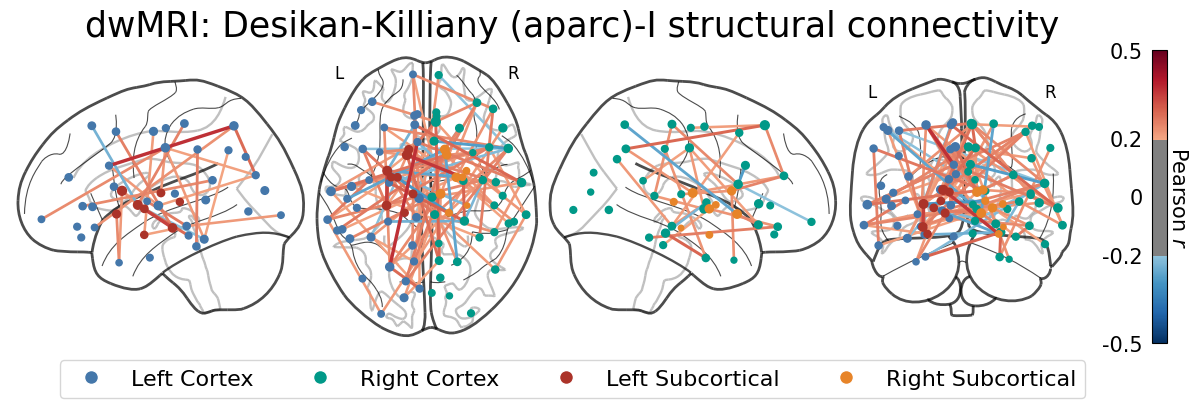

In [ ]:
# Final good plot
def plot_connectome_single_view(corr_matrix, pval_matrix, coords_df, display_mode='lyr', save_path=None):
    """Clean connectome plot with proper 4-color scheme"""
    # Apply thresholds
    sig_mask = (pval_matrix < 0.05) & (np.abs(corr_matrix) > 0.0)
    thresholded_corr = corr_matrix * sig_mask
    
    # Get significant nodes
    significant_nodes = np.where(np.any(sig_mask.values, axis=0))[0]
    significant_data = coords_df.iloc[significant_nodes]
    
    # Prepare plot data
    plot_coords = significant_data[['x.mni', 'y.mni', 'z.mni']].values
    plot_corr = thresholded_corr.iloc[significant_nodes, significant_nodes]
    
    # Calculate node sizes
    node_size = np.sum(np.abs(plot_corr), axis=0) * 5
    
    # Define 4-color scheme
    node_colors = []
    for _, row in significant_data.iterrows():
        if row['type'] == 'subcortical':
            node_colors.append('#AB3329FF' if row['hemi'] == 'lh' else '#E78429FF')
        else:
            node_colors.append('#4477AAFF' if row['hemi'] == 'lh' else '#009988FF')
    
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 1, width_ratios=[1], bottom=0.2, top=0.85)  # Extra space at bottom

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_white_center", ["#4F5791FF", "#F7ECD8FF", "#A40000FF"])

    ax = fig.add_subplot(gs[0])
    display = plot_connectome(
        adjacency_matrix=plot_corr.values,
        node_coords=plot_coords,
        node_color=node_colors,
        node_size=node_size,
        edge_cmap='RdBu_r', # cmap,
        edge_vmin=-0.5,
        edge_vmax=0.5,
        edge_threshold=0.2,
        display_mode=display_mode,
        axes=ax,
        colorbar=True,
        figure=fig,
        #annotate=True,
    )


    # Create unified legend at bottom
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Left Cortex',
                  markerfacecolor='#4477AAFF', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Right Cortex',
                  markerfacecolor='#009988FF', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Left Subcortical',
                  markerfacecolor='#AB3329FF', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Right Subcortical',
                  markerfacecolor='#E78429FF', markersize=10)
    ]
    
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=4,
        bbox_to_anchor=(0.5, 0.1),  # Adjusted lower
        frameon=True,
        fontsize=16
    )
    
    colorbar = display._cbar
    if colorbar is not None:
         # Set colorbar label
        colorbar.set_label('Pearson $r$', rotation=270, labelpad=15, fontsize=15)
        # Adjust colorbar tick font size
        colorbar.ax.tick_params(labelsize=15)

    # Central title with adjusted position
    fig.suptitle(
        "dwMRI: Desikan-Killiany (aparc)-I structural connectivity",
        #"Significant associations with observed $g$-factor",
        y=0.9,
        fontsize=25
    )
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

fig_path = '/feature-imp/figures'
plot_connectome_single_view(corr_matrix, pval_matrix, aparc_s1_coords, display_mode='lzry', save_path=os.path.join(fig_path, 'fi-dti.png'))

In [ ]:
from nilearn import plotting

def plot_interactive_connectome(corr_matrix, pval_matrix, coords_df, edge_threshold='90%'):
    """Interactive 3D connectome plot with 4-color scheme"""
    # Apply thresholds (same as before)
    sig_mask = (pval_matrix < 0.05) & (np.abs(corr_matrix) > 0.0)
    thresholded_corr = corr_matrix * sig_mask
    
    # Get significant nodes
    significant_nodes = np.where(np.any(sig_mask.values, axis=0))[0]
    significant_data = coords_df.iloc[significant_nodes]
    
    # Prepare data for interactive viewer
    plot_coords = significant_data[['x.mni', 'y.mni', 'z.mni']].values
    plot_corr = thresholded_corr.iloc[significant_nodes, significant_nodes].values
    
    # Define 4-color scheme (same as before)
    node_colors = []
    for _, row in significant_data.iterrows():
        if row['type'] == 'subcortical':
            node_colors.append('#AB3329' if row['hemi'] == 'lh' else '#E78429')
        else:
            node_colors.append('#4477AA' if row['hemi'] == 'lh' else '#009988')
    
    # Create interactive viewer
    view = plotting.view_connectome(
        adjacency_matrix=plot_corr,
        node_coords=plot_coords,
        edge_threshold=0.2,
        node_color=node_colors,
        node_size=10,  # Fixed size or can calculate as before
        edge_cmap='RdBu_r',
        symmetric_cmap=True,
        title="Interactive Connectome"
    )


    return view

# Usage example:
view = plot_interactive_connectome(corr_matrix, pval_matrix, aparc_s1_coords, edge_threshold=0.2)
view.open_in_browser()  # Opens in default browser
view  # If in Jupyter notebook, will display inline

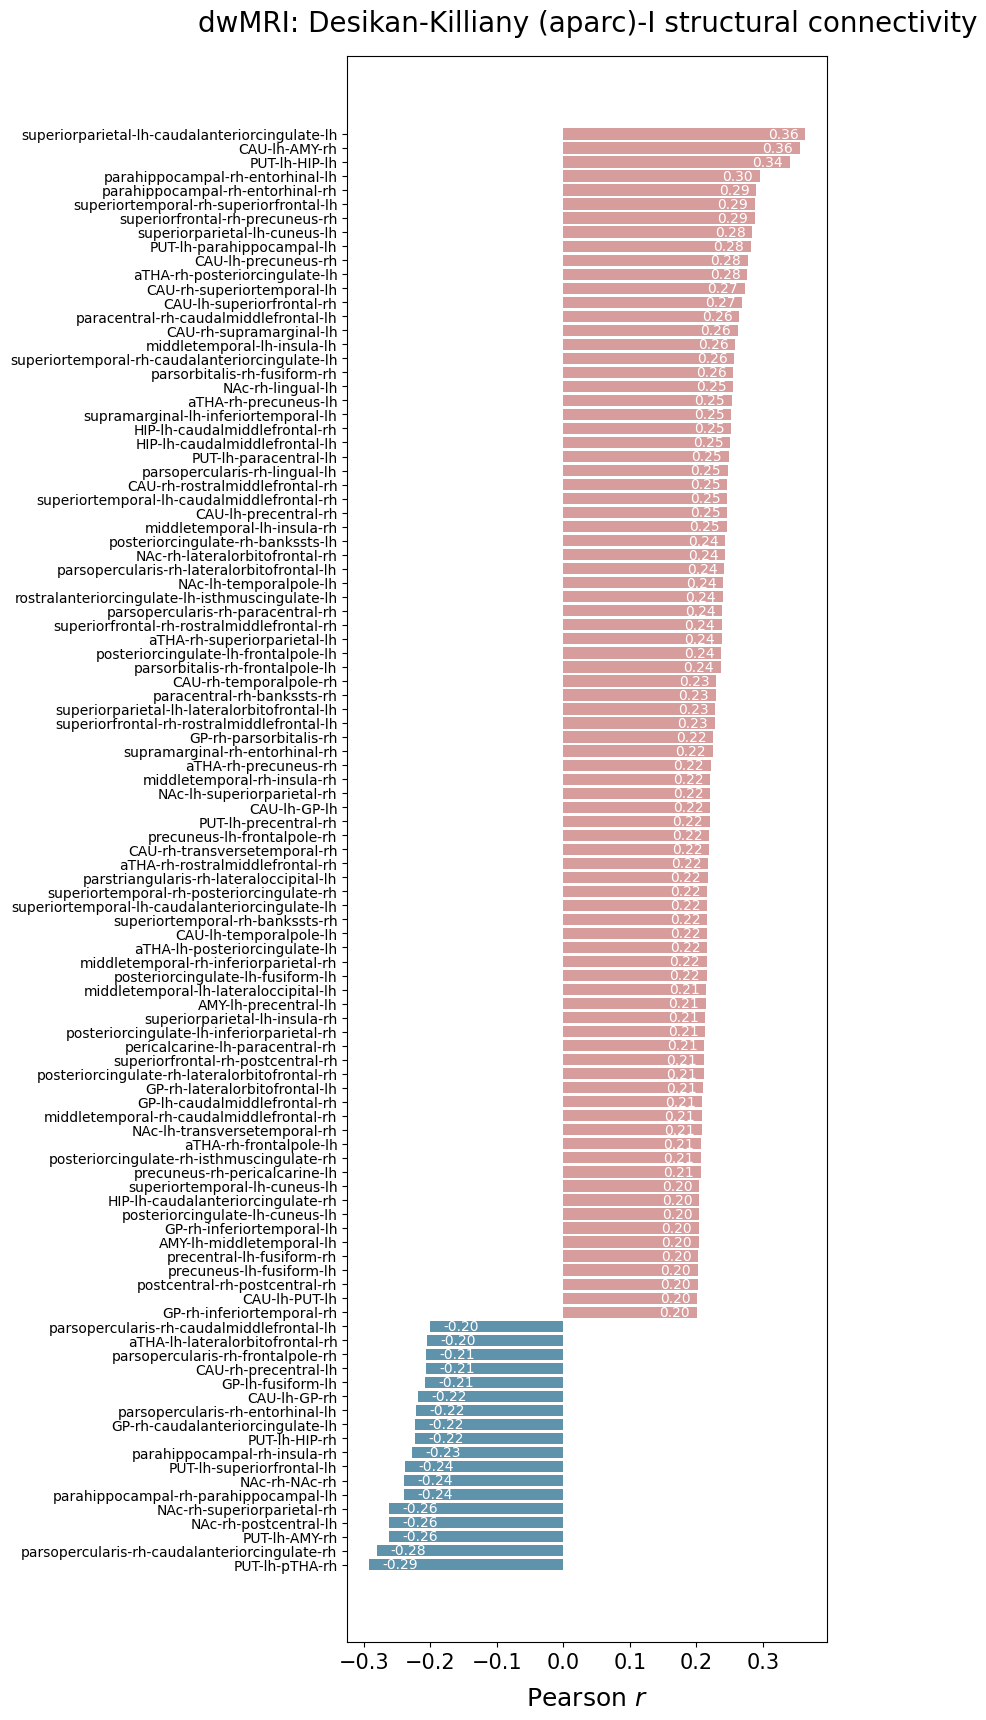

In [ ]:
# Barplot r> 0.2
# Filter for significant correlations (p < 0.05) and absolute correlation > 0.2
plot_df_filtered = corr_with_g_pred[
    (corr_with_g_pred['p_value_g_pred'] < 0.05) & 
    (corr_with_g_pred['corr_with_g_pred'].abs() > 0.2)
].copy()

# Sort the filtered data
ordered = (plot_df_filtered
         .assign(abs_corr = plot_df_filtered['corr_with_g_pred'].abs())
         .sort_values('abs_corr', ascending=False)
         ).sort_values('corr_with_g_pred', ascending=False)

# Create the figure - adjust size based on number of features
n_bars = len(ordered)
plt.figure(figsize=(8, max(6, n_bars * 0.2)), dpi=100)  # Increased height multiplier

# Create color list - blue for positive, red for negative
colors = ['#D79C9CFF' if x > 0 else '#5F93ACFF' for x in ordered['corr_with_g_pred']]

# Create horizontal bars using connection names
bars = plt.barh(ordered['connection'],  # Using the connection names now
                ordered['corr_with_g_pred'], 
                color=colors,
                #alpha=0.7,
                height=0.8)  # Increased bar thickness

# Add correlation values on bars
for bar, corr in zip(bars, ordered['corr_with_g_pred']):
    width = bar.get_width()
    label_x = width - 0.01 if width > 0 else width + 0.02
    plt.text(label_x, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left',
             color='white', fontsize=10)

# Formatting
plt.title('dwMRI: Desikan-Killiany (aparc)-I structural connectivity', 
          pad=18, fontsize=20)
plt.xlabel('Pearson $r$', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('')
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()  # Highest values at top

# Adjust layout with more space for long labels
#plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Add more space on left for long labels

fig_path = '/feature-imp/figures/supplem'
plt.savefig(os.path.join(fig_path, 'fi-dwmri-BARS.jpg'), 
            dpi=350,  # Increased from 300 to 350
            bbox_inches='tight')

plt.show()